In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np
from copy import deepcopy

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are used:
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. LeNet-5

![LeNet-5](images\lenet5.png)

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
class LeNet5(nn.Module):
    """ Represents LeNet-5 convolutional neural network. """
    
    def __init__(self, output_size):
        """ Initialize LeNet-5.
        
        Args:
            output_size:
                size of output (number of labels), as an integer.
        """
        super(LeNet5, self).__init__()
        
        # activation function
        self.activation = nn.Tanh()
        
        # convolutional layer: CONV1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        
        # convolutional layer: CONV3
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        # average pooling layer 
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=output_size)
        
    def forward(self, x):
        # Input --> CONV1 --> NORM --> ReLU --> POOL2
        x = self.pool(self.activation(self.conv1(x)))
        
        # CONV3 → NORM → ReLU → POOL4
        x = self.pool(self.activation(self.conv2(x)))
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        
        # CONV5
        logits = self.activation(self.fc1(x))
        
        # FC6
        logits = self.activation(self.fc2(logits))
        
        # outpout
        logits = self.fc3(logits)
        
        return logits

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| LeNet-5                       | 1.22            | 58%                 |

Best trial **configuration** for LeNet-5: lr: 0.0001, l2: 0.0001

In [6]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    model = LeNet5(output_size=num_labels)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [7]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [8]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4]),
    }

In [9]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=30,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-09-03 10:56:27,149	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-09-03 10:56:39,672	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-09-03 10:56:40,172	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (4 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_786ab_00000 | PENDING  |       | 0.001  | 0.001  |
| tune_helper_786ab_00001 | PENDING  |       | 0.0001 | 0.001  |
| tune_helper_786ab_00002 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_786ab_00003 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 7.1/7.9 GiB: ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpe

Result for tune_helper_786ab_00000:
  accuracy: 0.5267
  date: 2021-09-03_10-58-00
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.3390320896343062
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 78.98803353309631
  time_this_iter_s: 14.487865924835205
  time_total_s: 78.98803353309631
  timestamp: 1630655880
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 6.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+--

Result for tune_helper_786ab_00000:
  accuracy: 0.5487
  date: 2021-09-03_10-59-12
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 9
  loss: 1.289889517483438
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 150.7467119693756
  time_this_iter_s: 14.413563251495361
  time_total_s: 150.7467119693756
  timestamp: 1630655952
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+---

Result for tune_helper_786ab_00000:
  accuracy: 0.546
  date: 2021-09-03_11-00-17
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 14
  loss: 1.3362227427731654
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 216.13672542572021
  time_this_iter_s: 12.076263189315796
  time_total_s: 216.13672542572021
  timestamp: 1630656017
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------

Result for tune_helper_786ab_00000:
  accuracy: 0.5357
  date: 2021-09-03_11-01-19
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.4621439663467892
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 278.4561002254486
  time_this_iter_s: 13.162080764770508
  time_total_s: 278.4561002254486
  timestamp: 1630656079
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_786ab_00000:
  accuracy: 0.552
  date: 2021-09-03_11-02-16
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 24
  loss: 1.4588230518019123
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 335.3388669490814
  time_this_iter_s: 11.401505470275879
  time_total_s: 335.3388669490814
  timestamp: 1630656136
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+-

Result for tune_helper_786ab_00000:
  accuracy: 0.5484
  date: 2021-09-03_11-03-14
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 29
  loss: 1.515802873168022
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 392.5320315361023
  time_this_iter_s: 11.469698429107666
  time_total_s: 392.5320315361023
  timestamp: 1630656194
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+-

Result for tune_helper_786ab_00000:
  accuracy: 0.5461
  date: 2021-09-03_11-04-10
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 34
  loss: 1.5250239121686122
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 448.9327881336212
  time_this_iter_s: 11.18814468383789
  time_total_s: 448.9327881336212
  timestamp: 1630656250
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-05-08
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 39
  loss: 1.5290613880582675
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 506.6991698741913
  time_this_iter_s: 11.2889084815979
  time_total_s: 506.6991698741913
  timestamp: 1630656308
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------

Result for tune_helper_786ab_00000:
  accuracy: 0.5456
  date: 2021-09-03_11-06-06
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 44
  loss: 1.5347082185897098
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 565.1330134868622
  time_this_iter_s: 12.189360618591309
  time_total_s: 565.1330134868622
  timestamp: 1630656366
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_786ab_00000:
  accuracy: 0.5458
  date: 2021-09-03_11-07-04
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 49
  loss: 1.5304180565913013
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 622.925831079483
  time_this_iter_s: 11.49361515045166
  time_total_s: 622.925831079483
  timestamp: 1630656424
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+------------------

Result for tune_helper_786ab_00000:
  accuracy: 0.546
  date: 2021-09-03_11-08-01
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 54
  loss: 1.5347524004377378
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 680.3416285514832
  time_this_iter_s: 11.851853132247925
  time_total_s: 680.3416285514832
  timestamp: 1630656481
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-08-58
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 59
  loss: 1.5358674078230645
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 736.6171669960022
  time_this_iter_s: 11.357746362686157
  time_total_s: 736.6171669960022
  timestamp: 1630656538
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-09-55
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 64
  loss: 1.5339200568806595
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 793.8852288722992
  time_this_iter_s: 11.195719003677368
  time_total_s: 793.8852288722992
  timestamp: 1630656595
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-10-52
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 69
  loss: 1.531189276534281
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 850.5211472511292
  time_this_iter_s: 11.314762592315674
  time_total_s: 850.5211472511292
  timestamp: 1630656652
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-11-49
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 74
  loss: 1.5345246685538323
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 907.5251586437225
  time_this_iter_s: 11.184612035751343
  time_total_s: 907.5251586437225
  timestamp: 1630656709
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-12-45
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 79
  loss: 1.5332549518081033
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 964.2817387580872
  time_this_iter_s: 11.17467999458313
  time_total_s: 964.2817387580872
  timestamp: 1630656765
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-13-42
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 84
  loss: 1.5307462352096655
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 1021.2832551002502
  time_this_iter_s: 11.515644550323486
  time_total_s: 1021.2832551002502
  timestamp: 1630656822
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+---------

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-14-39
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 89
  loss: 1.5327826556126782
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 1078.4585011005402
  time_this_iter_s: 11.588619709014893
  time_total_s: 1078.4585011005402
  timestamp: 1630656879
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+---------

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-15-36
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 94
  loss: 1.5388574725503374
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 1134.795147895813
  time_this_iter_s: 11.304826736450195
  time_total_s: 1134.795147895813
  timestamp: 1630656936
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_786ab_00000:
  accuracy: 0.5459
  date: 2021-09-03_11-16-42
  done: false
  experiment_id: f8af5267ca42443094537ac4fa07c041
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 99
  loss: 1.5336503200470262
  node_ip: 192.168.1.20
  pid: 16220
  time_since_restore: 1201.3863816261292
  time_this_iter_s: 13.83353853225708
  time_total_s: 1201.3863816261292
  timestamp: 1630657002
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 786ab_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

(pid=16220) Windows fatal exception: access violation
(pid=16220) 


Result for tune_helper_786ab_00001:
  accuracy: 0.4292
  date: 2021-09-03_11-17-53
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.6126750426687253
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 31.04651641845703
  time_this_iter_s: 31.04651641845703
  time_total_s: 31.04651641845703
  timestamp: 1630657073
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_786ab_00001:
  accuracy: 0.5368
  date: 2021-09-03_11-18-51
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 1.3076051150917247
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 89.6467182636261
  time_this_iter_s: 12.020056009292603
  time_total_s: 89.6467182636261
  timestamp: 1630657131
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+-

Result for tune_helper_786ab_00001:
  accuracy: 0.5572
  date: 2021-09-03_11-19-49
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 1.2936861970622069
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 147.27960658073425
  time_this_iter_s: 11.518714904785156
  time_total_s: 147.27960658073425
  timestamp: 1630657189
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.5553
  date: 2021-09-03_11-20-46
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.3562009964778925
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 204.66237473487854
  time_this_iter_s: 11.312099695205688
  time_total_s: 204.66237473487854
  timestamp: 1630657246
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.5584
  date: 2021-09-03_11-21-42
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 1.4033995604818794
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 260.99318981170654
  time_this_iter_s: 11.11094331741333
  time_total_s: 260.99318981170654
  timestamp: 1630657302
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.5554
  date: 2021-09-03_11-22-39
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 1.4478599884707457
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 317.82455253601074
  time_this_iter_s: 11.193060636520386
  time_total_s: 317.82455253601074
  timestamp: 1630657359
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.5176319316693931
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.5549
  date: 2021-09-03_11-23-36
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 1.4885851057471744
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 374.62734174728394
  time_this_iter_s: 11.189090251922607
  time_total_s: 374.62734174728394
  timestamp: 1630657416
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.5548
  date: 2021-09-03_11-24-33
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 1.4829246849770759
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 431.30326652526855
  time_this_iter_s: 11.637107610702515
  time_total_s: 431.30326652526855
  timestamp: 1630657473
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.5527
  date: 2021-09-03_11-25-29
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 1.4956111144867672
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 487.6711139678955
  time_this_iter_s: 11.497725248336792
  time_total_s: 487.6711139678955
  timestamp: 1630657529
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.5536
  date: 2021-09-03_11-26-25
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 1.4925871521803984
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 543.7959735393524
  time_this_iter_s: 11.354066371917725
  time_total_s: 543.7959735393524
  timestamp: 1630657585
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-27-22
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 1.4914071928164003
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 600.4821772575378
  time_this_iter_s: 11.098431825637817
  time_total_s: 600.4821772575378
  timestamp: 1630657642
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-28-19
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 1.492318231588716
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 657.1109063625336
  time_this_iter_s: 11.213263988494873
  time_total_s: 657.1109063625336
  timestamp: 1630657699
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5342781023614724 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-29-15
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 1.492014531117336
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 713.5514996051788
  time_this_iter_s: 11.306745052337646
  time_total_s: 713.5514996051788
  timestamp: 1630657755
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-30-12
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 1.4914086176331636
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 770.1547892093658
  time_this_iter_s: 11.416189432144165
  time_total_s: 770.1547892093658
  timestamp: 1630657812
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-31-09
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 1.4919261347716022
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 827.5535254478455
  time_this_iter_s: 11.41297960281372
  time_total_s: 827.5535254478455
  timestamp: 1630657869
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-32-06
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 1.4858820436486773
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 884.091165304184
  time_this_iter_s: 11.454145431518555
  time_total_s: 884.091165304184
  timestamp: 1630657926
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-33-02
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 1.4919868392549502
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 940.2596447467804
  time_this_iter_s: 11.22461748123169
  time_total_s: 940.2596447467804
  timestamp: 1630657982
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-33-58
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 1.494171086390307
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 996.9751749038696
  time_this_iter_s: 11.310282468795776
  time_total_s: 996.9751749038696
  timestamp: 1630658038
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-34-55
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 1.4939598980223296
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 1053.490330696106
  time_this_iter_s: 11.384406328201294
  time_total_s: 1053.490330696106
  timestamp: 1630658095
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_786ab_00001:
  accuracy: 0.554
  date: 2021-09-03_11-35-52
  done: false
  experiment_id: 5fb8656508a3498887ef1bbc71ca93ed
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 1.4912673603197573
  node_ip: 192.168.1.20
  pid: 16564
  time_since_restore: 1110.1337192058563
  time_this_iter_s: 11.454121112823486
  time_total_s: 1110.1337192058563
  timestamp: 1630658152
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 786ab_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

(pid=16564) Windows fatal exception: access violation
(pid=16564) 


Result for tune_helper_786ab_00002:
  accuracy: 0.3453
  date: 2021-09-03_11-36-53
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.8602903716883081
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 14.494250297546387
  time_this_iter_s: 14.494250297546387
  time_total_s: 14.494250297546387
  timestamp: 1630658213
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.4396
  date: 2021-09-03_11-37-49
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 1.6034041286274126
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 70.58261394500732
  time_this_iter_s: 11.230936288833618
  time_total_s: 70.58261394500732
  timestamp: 1630658269
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.4778
  date: 2021-09-03_11-38-46
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 1.4693403350319831
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 127.3848831653595
  time_this_iter_s: 11.928230285644531
  time_total_s: 127.3848831653595
  timestamp: 1630658326
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5008
  date: 2021-09-03_11-39-42
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.398711080004455
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 183.6228711605072
  time_this_iter_s: 11.297183275222778
  time_total_s: 183.6228711605072
  timestamp: 1630658382
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5169
  date: 2021-09-03_11-40-41
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 1.353528863305499
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 242.416597366333
  time_this_iter_s: 12.634157180786133
  time_total_s: 242.416597366333
  timestamp: 1630658441
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+

Result for tune_helper_786ab_00002:
  accuracy: 0.5289
  date: 2021-09-03_11-41-59
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 1.3272157512652647
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 320.1868431568146
  time_this_iter_s: 11.622052669525146
  time_total_s: 320.1868431568146
  timestamp: 1630658519
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4998787345400282
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5375
  date: 2021-09-03_11-42-58
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 1.3049461389802823
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 379.3813638687134
  time_this_iter_s: 11.458272933959961
  time_total_s: 379.3813638687134
  timestamp: 1630658578
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5438
  date: 2021-09-03_11-43-57
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 1.2857461465392144
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 438.34044790267944
  time_this_iter_s: 11.206494808197021
  time_total_s: 438.34044790267944
  timestamp: 1630658637
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5502
  date: 2021-09-03_11-44-54
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 1.276625394821167
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 495.0033633708954
  time_this_iter_s: 11.09575891494751
  time_total_s: 495.0033633708954
  timestamp: 1630658694
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.551
  date: 2021-09-03_11-45-51
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 1.271545929513919
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 551.9485607147217
  time_this_iter_s: 11.378361463546753
  time_total_s: 551.9485607147217
  timestamp: 1630658751
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5533
  date: 2021-09-03_11-46-47
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 1.269064583216503
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 608.4116237163544
  time_this_iter_s: 11.19530439376831
  time_total_s: 608.4116237163544
  timestamp: 1630658807
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5573
  date: 2021-09-03_11-47-44
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 1.2592387096897053
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 664.9875912666321
  time_this_iter_s: 11.30237603187561
  time_total_s: 664.9875912666321
  timestamp: 1630658864
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.5139442881581129 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.559
  date: 2021-09-03_11-48-40
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 1.2777070543568605
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 721.2024669647217
  time_this_iter_s: 11.304895162582397
  time_total_s: 721.2024669647217
  timestamp: 1630658920
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5622
  date: 2021-09-03_11-49-36
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 1.2569123293943465
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 777.6466672420502
  time_this_iter_s: 11.22311282157898
  time_total_s: 777.6466672420502
  timestamp: 1630658976
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5624
  date: 2021-09-03_11-50-33
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 1.2617158358264122
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 834.1137821674347
  time_this_iter_s: 11.12273907661438
  time_total_s: 834.1137821674347
  timestamp: 1630659033
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5684
  date: 2021-09-03_11-51-29
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 1.2502416007837671
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 890.2923638820648
  time_this_iter_s: 11.208624601364136
  time_total_s: 890.2923638820648
  timestamp: 1630659089
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5694
  date: 2021-09-03_11-52-26
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 1.249294399455854
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 947.0630509853363
  time_this_iter_s: 11.696716070175171
  time_total_s: 947.0630509853363
  timestamp: 1630659146
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5688
  date: 2021-09-03_11-53-22
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 1.250573034878749
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 1002.9381191730499
  time_this_iter_s: 11.148778200149536
  time_total_s: 1002.9381191730499
  timestamp: 1630659202
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5705
  date: 2021-09-03_11-54-19
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 1.249150829710019
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 1060.1582090854645
  time_this_iter_s: 11.433646440505981
  time_total_s: 1060.1582090854645
  timestamp: 1630659259
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_786ab_00002:
  accuracy: 0.5714
  date: 2021-09-03_11-55-15
  done: false
  experiment_id: 21f535e13bac4c6c8a78aa8a5213e7e1
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 1.248918129000694
  node_ip: 192.168.1.20
  pid: 15868
  time_since_restore: 1116.027241230011
  time_this_iter_s: 11.180840730667114
  time_total_s: 1116.027241230011
  timestamp: 1630659315
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 786ab_00002
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

(pid=15868) Windows fatal exception: access violation
(pid=15868) 


Result for tune_helper_786ab_00003:
  accuracy: 0.3419
  date: 2021-09-03_11-56-17
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.8791089057922363
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 14.517203330993652
  time_this_iter_s: 14.517203330993652
  time_total_s: 14.517203330993652
  timestamp: 1630659377
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.4315
  date: 2021-09-03_11-57-15
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 1.6059171743453688
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 71.81373620033264
  time_this_iter_s: 11.658021688461304
  time_total_s: 71.81373620033264
  timestamp: 1630659435
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_786ab_00003:
  accuracy: 0.4708
  date: 2021-09-03_11-58-14
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 1.469115803196172
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 130.63854479789734
  time_this_iter_s: 11.557538509368896
  time_total_s: 130.63854479789734
  timestamp: 1630659494
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

Result for tune_helper_786ab_00003:
  accuracy: 0.5024
  date: 2021-09-03_11-59-10
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.3879741734000528
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 187.15523552894592
  time_this_iter_s: 11.23186707496643
  time_total_s: 187.15523552894592
  timestamp: 1630659550
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

Result for tune_helper_786ab_00003:
  accuracy: 0.5194
  date: 2021-09-03_12-00-07
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 1.3465162713056917
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 243.66993737220764
  time_this_iter_s: 11.292811632156372
  time_total_s: 243.66993737220764
  timestamp: 1630659607
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------

Result for tune_helper_786ab_00003:
  accuracy: 0.5353
  date: 2021-09-03_12-01-03
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 1.2962526462639972
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 299.90880060195923
  time_this_iter_s: 11.220157384872437
  time_total_s: 299.90880060195923
  timestamp: 1630659663
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.4821255374106632
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------

Result for tune_helper_786ab_00003:
  accuracy: 0.5437
  date: 2021-09-03_12-01-59
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 1.2842918653397044
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 356.3522710800171
  time_this_iter_s: 11.616698265075684
  time_total_s: 356.3522710800171
  timestamp: 1630659719
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.5533
  date: 2021-09-03_12-02-55
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 1.2623255571741967
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 412.3214979171753
  time_this_iter_s: 11.129016876220703
  time_total_s: 412.3214979171753
  timestamp: 1630659775
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.5602
  date: 2021-09-03_12-03-52
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 1.2454115645900654
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 468.63152289390564
  time_this_iter_s: 11.258279085159302
  time_total_s: 468.63152289390564
  timestamp: 1630659832
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------

Result for tune_helper_786ab_00003:
  accuracy: 0.5675
  date: 2021-09-03_12-04-48
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 1.2403606332031785
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 525.023515701294
  time_this_iter_s: 11.231897354125977
  time_total_s: 525.023515701294
  timestamp: 1630659888
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_786ab_00003:
  accuracy: 0.5683
  date: 2021-09-03_12-05-44
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 1.2323208265243821
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 581.108226776123
  time_this_iter_s: 11.087180852890015
  time_total_s: 581.108226776123
  timestamp: 1630659944
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_786ab_00003:
  accuracy: 0.5718
  date: 2021-09-03_12-06-41
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 1.235981501211786
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 637.5535111427307
  time_this_iter_s: 11.14179539680481
  time_total_s: 637.5535111427307
  timestamp: 1630660001
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.4936104739547535 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_786ab_00003:
  accuracy: 0.5713
  date: 2021-09-03_12-07-37
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 1.2368555630847906
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 693.6119685173035
  time_this_iter_s: 11.246368408203125
  time_total_s: 693.6119685173035
  timestamp: 1630660057
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.5722
  date: 2021-09-03_12-08-33
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 1.2354048839799918
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 749.9738502502441
  time_this_iter_s: 11.613324403762817
  time_total_s: 749.9738502502441
  timestamp: 1630660113
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.5734
  date: 2021-09-03_12-09-29
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 1.2380825535506959
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 806.0630238056183
  time_this_iter_s: 11.508178234100342
  time_total_s: 806.0630238056183
  timestamp: 1630660169
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.583
  date: 2021-09-03_12-10-25
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 1.2244639681403044
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 862.3456070423126
  time_this_iter_s: 11.076062440872192
  time_total_s: 862.3456070423126
  timestamp: 1630660225
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_786ab_00003:
  accuracy: 0.5821
  date: 2021-09-03_12-11-22
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 1.2250126106723858
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 918.5876960754395
  time_this_iter_s: 11.084380865097046
  time_total_s: 918.5876960754395
  timestamp: 1630660282
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.5839
  date: 2021-09-03_12-12-18
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 1.2250533358306641
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 975.0050613880157
  time_this_iter_s: 11.299095869064331
  time_total_s: 975.0050613880157
  timestamp: 1630660338
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_786ab_00003:
  accuracy: 0.5833
  date: 2021-09-03_12-13-14
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 1.227041313602666
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 1031.3337144851685
  time_this_iter_s: 11.204861402511597
  time_total_s: 1031.3337144851685
  timestamp: 1630660394
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

Result for tune_helper_786ab_00003:
  accuracy: 0.5839
  date: 2021-09-03_12-14-11
  done: false
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 1.2233694879112729
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 1087.6111822128296
  time_this_iter_s: 11.47287893295288
  time_total_s: 1087.6111822128296
  timestamp: 1630660451
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

2021-09-03 12:14:55,792	INFO tune.py:550 -- Total run time: 4696.12 seconds (4695.66 seconds for the tuning loop).


Result for tune_helper_786ab_00003:
  accuracy: 0.5832
  date: 2021-09-03_12-14-55
  done: true
  experiment_id: 40fe8183f4064799a95d16b888735f3f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 100
  loss: 1.2270658676791344
  node_ip: 192.168.1.20
  pid: 17312
  time_since_restore: 1132.1330189704895
  time_this_iter_s: 11.224461078643799
  time_total_s: 1132.1330189704895
  timestamp: 1630660495
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 786ab_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.3735305279683154 | Iter 30.000: -1.3952899840986652
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.96 GiB heap, 0.0/0.98 GiB objects (0.0/1.0 GPU_group_e785f9155459916583dc599a3efd1b9c, 0.0/1.0 GPU_group_0_e785f9155459916583dc599a3efd1b9c)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-03_10-56-39
Number of trials: 4/4 (4 TERMINATED)
+-------------------------+------------+-----

(pid=17312) Windows fatal exception: access violation
(pid=17312) 


Best trial config: {'lr': 0.0001, 'l2': 0.0001}
Best trial final validation loss: 1.2270658676791344
Best trial final validation acurracy: 0.5832


# 4. Fit and Predict

In [15]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [16]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
    
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.0001, l2: 0.0001

Results: 76
* Best **epoch**: 
* Best **train**: **accuracy**: 68.5%, **avg loss**: 0.897372
* Best **test**: **accuracy**: 58.3%, **avg loss**: 1.197808

In [17]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [19]:
num_labels = 10

model = LeNet5(output_size=num_labels).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
LeNet5(
  (activation): Tanh()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [20]:
learning_rate = 0.0001
weight_decay = 0.0001

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

## 5.2 Fit and predict

In [21]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        if torch.cuda.is_available():
            model.to(torch.device("cpu"))
            best_model_state_dict = deepcopy(model.state_dict())
            model.to(device)
        else:
            best_model_state_dict = deepcopy(model.state_dict())
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------
loss: 2.293739 [    0/50000]
loss: 1.992464 [ 6400/50000]
loss: 1.853159 [12800/50000]
loss: 1.949837 [19200/50000]
loss: 1.972849 [25600/50000]
loss: 1.801366 [32000/50000]
loss: 1.800627 [38400/50000]
loss: 1.936706 [44800/50000]

Train:
-------
accuracy: 35.4%, avg loss: 1.836304

Test:
-------
accuracy: 35.5%, avg loss: 1.832480

-------------------------------
Epoch 2
-------------------------------
loss: 1.681356 [    0/50000]
loss: 1.695572 [ 6400/50000]
loss: 1.723035 [12800/50000]
loss: 1.896203 [19200/50000]
loss: 1.683589 [25600/50000]
loss: 1.766898 [32000/50000]
loss: 1.549447 [38400/50000]
loss: 1.698867 [44800/50000]

Train:
-------
accuracy: 38.4%, avg loss: 1.734939

Test:
-------
accuracy: 38.6%, avg loss: 1.730952

-------------------------------
Epoch 3
-------------------------------
loss: 1.773901 [    0/50000]
loss: 1.524349 [ 6400/50000]
loss: 1.905981 [12800/50000]
loss: 1.666353 [19200/50000]
loss: 1.701531 [25600/50000]

loss: 1.209975 [ 6400/50000]
loss: 1.117067 [12800/50000]
loss: 1.394357 [19200/50000]
loss: 1.146185 [25600/50000]
loss: 1.305183 [32000/50000]
loss: 1.312046 [38400/50000]
loss: 1.133658 [44800/50000]

Train:
-------
accuracy: 56.2%, avg loss: 1.225733

Test:
-------
accuracy: 53.4%, avg loss: 1.294743

-------------------------------
Epoch 22
-------------------------------
loss: 1.267754 [    0/50000]
loss: 1.208962 [ 6400/50000]
loss: 1.355083 [12800/50000]
loss: 1.133517 [19200/50000]
loss: 1.338828 [25600/50000]
loss: 0.993348 [32000/50000]
loss: 1.116807 [38400/50000]
loss: 1.341375 [44800/50000]

Train:
-------
accuracy: 56.3%, avg loss: 1.222486

Test:
-------
accuracy: 53.4%, avg loss: 1.296766

-------------------------------
Epoch 23
-------------------------------
loss: 1.204155 [    0/50000]
loss: 1.413160 [ 6400/50000]
loss: 1.219269 [12800/50000]
loss: 1.298477 [19200/50000]
loss: 1.307310 [25600/50000]
loss: 1.347005 [32000/50000]
loss: 1.283529 [38400/50000]
loss: 1.

loss: 1.182929 [12800/50000]
loss: 0.834504 [19200/50000]
loss: 0.922785 [25600/50000]
loss: 1.034194 [32000/50000]
loss: 1.076215 [38400/50000]
loss: 1.213577 [44800/50000]

Train:
-------
accuracy: 62.3%, avg loss: 1.067266

Test:
-------
accuracy: 56.5%, avg loss: 1.226146

-------------------------------
Epoch 42
-------------------------------
loss: 1.040777 [    0/50000]
loss: 1.011151 [ 6400/50000]
loss: 0.828234 [12800/50000]
loss: 1.093858 [19200/50000]
loss: 1.104985 [25600/50000]
loss: 1.000991 [32000/50000]
loss: 1.005844 [38400/50000]
loss: 0.983366 [44800/50000]

Train:
-------
accuracy: 62.3%, avg loss: 1.060298

Test:
-------
accuracy: 56.9%, avg loss: 1.223073

-------------------------------
Epoch 43
-------------------------------
loss: 1.077793 [    0/50000]
loss: 1.219255 [ 6400/50000]
loss: 0.865195 [12800/50000]
loss: 1.256896 [19200/50000]
loss: 1.135517 [25600/50000]
loss: 0.891101 [32000/50000]
loss: 1.123137 [38400/50000]
loss: 1.143337 [44800/50000]

Train:


loss: 0.922936 [19200/50000]
loss: 0.988370 [25600/50000]
loss: 0.893526 [32000/50000]
loss: 0.966123 [38400/50000]
loss: 0.961108 [44800/50000]

Train:
-------
accuracy: 66.0%, avg loss: 0.960954

Test:
-------
accuracy: 57.6%, avg loss: 1.204719

-------------------------------
Epoch 62
-------------------------------
loss: 0.811155 [    0/50000]
loss: 0.964026 [ 6400/50000]
loss: 1.048566 [12800/50000]
loss: 0.899472 [19200/50000]
loss: 0.834716 [25600/50000]
loss: 0.763090 [32000/50000]
loss: 0.857796 [38400/50000]
loss: 1.229027 [44800/50000]

Train:
-------
accuracy: 66.2%, avg loss: 0.958856

Test:
-------
accuracy: 57.6%, avg loss: 1.212160

-------------------------------
Epoch 63
-------------------------------
loss: 0.780235 [    0/50000]
loss: 1.192221 [ 6400/50000]
loss: 0.874951 [12800/50000]
loss: 0.821635 [19200/50000]
loss: 1.031049 [25600/50000]
loss: 0.844315 [32000/50000]
loss: 1.285587 [38400/50000]
loss: 0.819370 [44800/50000]

Train:
-------
accuracy: 66.4%, avg 

loss: 0.939978 [25600/50000]
loss: 1.077263 [32000/50000]
loss: 1.059076 [38400/50000]
loss: 0.996178 [44800/50000]

Train:
-------
accuracy: 68.8%, avg loss: 0.894024

Test:
-------
accuracy: 58.1%, avg loss: 1.198302

-------------------------------
Epoch 82
-------------------------------
loss: 0.910009 [    0/50000]
loss: 0.789129 [ 6400/50000]
loss: 0.969128 [12800/50000]
loss: 0.896364 [19200/50000]
loss: 1.059580 [25600/50000]
loss: 0.795205 [32000/50000]
loss: 1.001041 [38400/50000]
loss: 0.830248 [44800/50000]

Train:
-------
accuracy: 68.8%, avg loss: 0.894190

Test:
-------
accuracy: 58.2%, avg loss: 1.198122

-------------------------------
Epoch 83
-------------------------------
loss: 0.716585 [    0/50000]
loss: 0.954396 [ 6400/50000]
loss: 1.010683 [12800/50000]
loss: 0.884631 [19200/50000]
loss: 0.837530 [25600/50000]
loss: 0.697698 [32000/50000]
loss: 0.993167 [38400/50000]
loss: 0.749264 [44800/50000]

Train:
-------
accuracy: 68.7%, avg loss: 0.893091

Test:
-------

## 5.3 Visualize training and testing

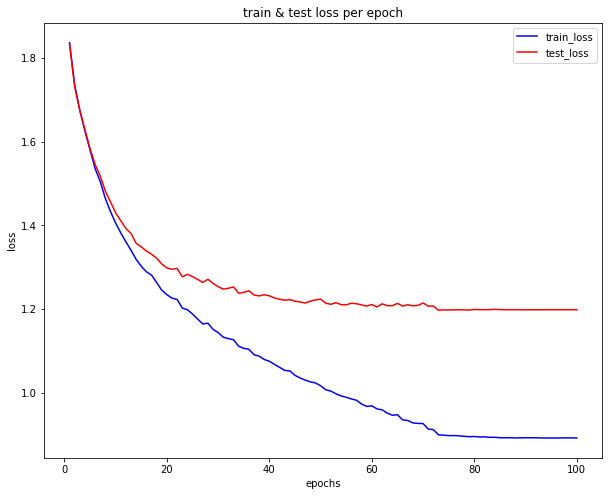

In [22]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

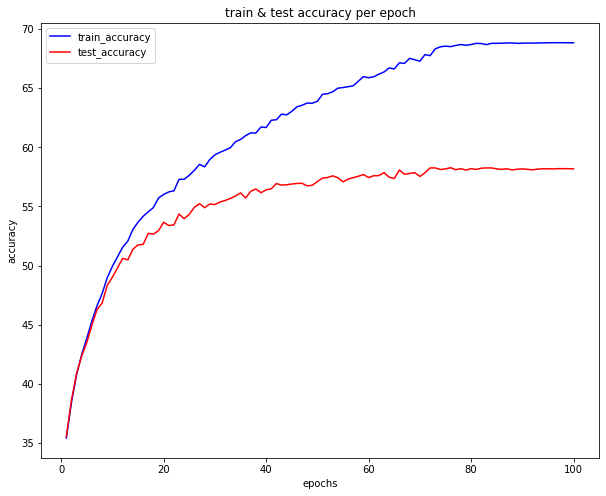

In [23]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [24]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 76
Train: accuracy: 68.5%, avg loss: 0.897372
Test: accuracy: 58.3%, avg loss: 1.197808


## 5.4 Model metrics

In [25]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.73      0.73      0.73      5000
  automobile       0.77      0.83      0.80      5000
        bird       0.59      0.55      0.57      5000
         cat       0.53      0.47      0.50      5000
        deer       0.63      0.60      0.62      5000
         dog       0.58      0.57      0.58      5000
        frog       0.70      0.77      0.74      5000
       horse       0.74      0.76      0.75      5000
        ship       0.78      0.82      0.80      5000
       truck       0.75      0.75      0.75      5000

    accuracy                           0.69     50000
   macro avg       0.68      0.69      0.68     50000
weighted avg       0.68      0.69      0.68     50000

Test:
              precision    recall  f1-score   support

    airplane       0.63      0.65      0.64      1000
  automobile       0.69      0.72      0.71      1000
        bird       0.50      0.43      0.46      1000
         ca

<AxesSubplot:>

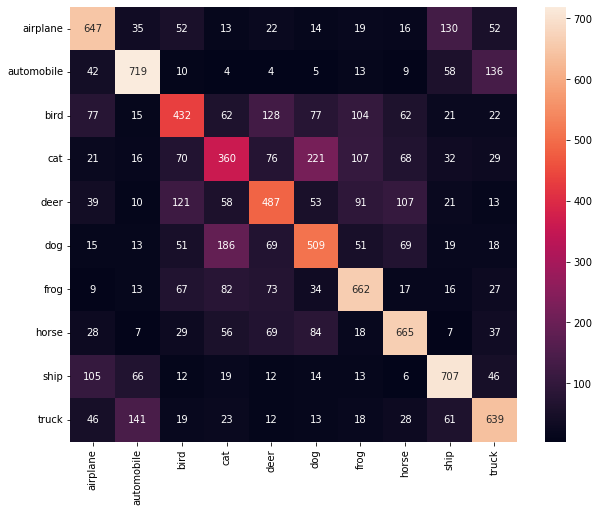

In [26]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [27]:
torch.save(best_model_state_dict, '../saved-model/lenet5-weights.pth')